<h3>Andrey Skobtsov</h3>

**БПИ 161**

**Report**

**1. The best model description**

Наилучшая модель использует все данные из исходного набора кроме `owner_id` и `product_id`, т.к. данные колонки не несут особого смысла. Были выполнены преобразования: `name_text` и `desc_text` были отфильтрованы от нетекстовых символов, потом разделены на слова, а слова приведены к начальной форме. Из элементов в `properties` были взяты пары `slug_id` <> `value_id`. Т.к. каждому элементу из `properties` соответствует не всегда единственная пара `slug_id` <> `value_id`, было решено для каждого элемента создать 2 фичи: строка из всех элементов `slug_id`, разделённых пробелом и строка из всех элементов `value_id`, разделённых пробелом, чтобы потом на это можно было бы натравить *TfidfVectorizer*. Каждая из дат в `date_created` была преобразована в 3 фичи (день/месяц/год). Остальные колонки были либо отнормализованы (`img_num`, `lat`, `long`, `price`, `day_created`, `month_created`, `year_created`) либо закодированы через OneHotEcoding (`city`, `product_type`, `region`, `category_id`, `subcategory_id`, `sold_mode`). 
Модель является лесом из дерева решений, который обучается с помощью градиентного бустинга (из описания в LightGBM).
Расчёт качества модели выполнялся с помощью `roc_auc_score` (метрика, использованная в kaggle).

**2. Key data findings**

Основное интересное, что удалось узнать, лучше использовать все фичи для увеличения точности. Из менее интересного: количество картинок коррелирует с типом продукта и количеством слов в тексте описания. Но это не очень полезно при обучении. Чуть информации об исследовании значений можно найти на несколько ячеек ниже на графике с корреляциями.
Единственное, что оказалось полезным, это узнать тот факт, что количество непроданных и проданных предметов сильно различается, в связи с этим использование stratified k-fold оправдано и даёт существенный прирост качества.

**3. Description of alternative approaches that you tried.**

Другие подходы заключались в использовании/не использовании k-fold, стоп слов, лемматизации, разных моделях и другое.
Расмотренные варианты с их показателями можно найти в google таблице: https://docs.google.com/spreadsheets/d/1d_SL4d14FMiHC9psI1BzmnyLeVhAuThntmOLU4DBeNo/edit

**Важно!**

При первом запуске необходимо изменить значение `load_existing` на `False` в одной из ячеек ниже. Данный параметр отвечает за необходимость лемматизации текстов, что занимает довольно продолжительное время (порядка 20 минут). После первого запуска можно изменить параметр на `True`, т.к. алгоритм автоматом сохранит обработанный текст в отдельный файл для последующей загрузки.

In [1]:
# imports

import re
import ast
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from typing import List, Pattern, Dict, Tuple
from scipy.sparse import csr_matrix, hstack
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from datetime import datetime
from tqdm import tqdm

In [2]:
data = pd.read_csv('data/train.tsv', sep='\t')
data.head()

,Unnamed: 0,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
0,1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
1,2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
2,4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
3,6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
4,10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


In [3]:
def get_parts(word: str) -> List[str]:
    parts: List[str] = []
    part = ''
    for symbol in word:
        if symbol in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя':
            part += symbol
        else:
            if part:
                parts.append(part)
                part = ''
    if part:
        parts.append(part)
    return parts

def get_parts_count(word: str) -> int:
    parts = 0
    have_symbol = False
    for symbol in word:
        if symbol in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя':
            have_symbol = True
        else:
            if have_symbol:
                parts += 1
                have_symbol = False
    if have_symbol:
        parts += 1
    return parts

def to_parts_count(items: List[str]) -> List[int]:
    return [get_parts_count(item) for item in items]

In [4]:
ndata = data.copy()
ndata['desc_text_parts'] = to_parts_count(data['desc_text'])
ndata['name_text_parts'] = to_parts_count(data['name_text'])
ndata['exclamations'] = ndata['desc_text'].apply(lambda x: x.count('!'))
ndata.drop(['Unnamed: 0', 'desc_text', 'owner_id', 'product_id', 'properties', 'city', 'date_created', 'name_text', 'region'], axis=1, inplace=True)
ndata.head()

,category_id,delivery_available,img_num,lat,long,payment_available,price,product_type,sold_mode,subcategory_id,sold_fast,desc_text_parts,name_text_parts,exclamations
0,4,False,3,45.0686,38.9518,True,500.0,1,1,410,1,13,1,0
1,4,False,2,57.1840,65.5674,False,300.0,1,1,405,0,24,1,0
2,9,True,1,54.9889,73.4312,True,1100.0,1,1,908,0,20,1,0
3,3,False,4,59.9590,30.4877,True,5000.0,1,1,312,0,75,1,0
4,5,False,2,55.6473,37.4118,True,2000.0,1,1,504,0,11,2,0


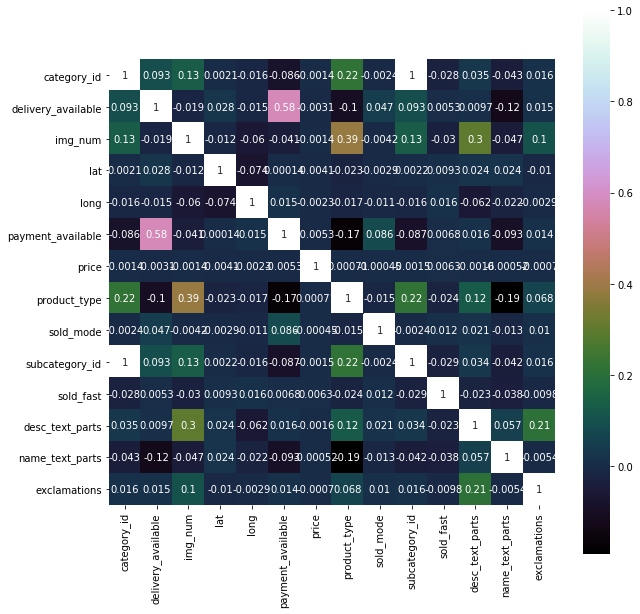

In [5]:
def plot_correlation(data):
    correlation = data.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')  
    
plot_correlation(ndata)

In [6]:
def concat_dataframes(*dataframes: Tuple[pd.DataFrame]) -> pd.DataFrame:
    for df in dataframes:
        df.reset_index(drop=True, inplace=True)
        
    return pd.concat(dataframes, axis=1)

def load_data(file: str, load_processed: bool) -> pd.DataFrame:
    if load_processed:
        return pd.read_csv(f'data_processed/{file}.tsv', sep='\t')
    
    analyzer = MorphAnalyzer(result_type=None)
    lines_and_breaks_regex: Pattern = re.compile('\-\s\r\n\s{1,}|\-\s\r\n|\r\n|<br>')
    symbols_regex: Pattern = re.compile('[.,:;%©?*,!@#$%^&()\d«»\|✅⚡️✨☀●☀️❤️•❗❄️]|[+=]|[[]|[]]|[/]|"|\s{2,}|-')
    
    def filter_symbols(text: str) -> List[str]:
        text = text.lower()
        text = lines_and_breaks_regex.sub('', text) #deleting newlines and line-breaks
        text = symbols_regex.sub(' ', text) #deleting symbols 
        return text.split()
    
    def lemmatize(text: str) -> List[str]:
        return [analyzer.parse(word)[0][2] for word in filter_symbols(text)]

    def lemmatize_filtered(words: List[str]) -> list:
        return [analyzer.parse(word)[0][2] for word in words]
    
    def lemmatize_list(inp: Iterable[str]) -> List[str]:
        return [' '.join(lemmatize(text)) for text in inp]

    data = pd.read_csv(f'data/{file}.tsv', sep='\t')
    
    name_text_lemmatized: List[str] = lemmatize_list(data['name_text'])
    desc_text_lemmatized: List[str] = lemmatize_list(data['desc_text'])
    
    lemmatized_df = pd.DataFrame.from_dict({
        'name_text_lemmatized': name_text_lemmatized, 
        'desc_text_lemmatized': desc_text_lemmatized
    })
    
    data = concat_dataframes(data, lemmatized_df)
    
    processed_dir = 'data_processed'
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)
    data.to_csv(f'{processed_dir}/{file}.tsv', encoding='utf-8', index=False, sep='\t')
    
    return data

def get_prop_values(data) -> Dict[str, np.array]:
    result_list = []
    
    for prop in data:
        if prop is None:
            parsed = []
        else:
            parsed = ast.literal_eval(prop)
    
        slug_ids = []
        value_ids = []
        for item in parsed:
            slug_ids.append(item['slug_id'])
            value_ids.append(item['value_id'])

        result_list.append([' '.join(slug_ids), ' '.join(map(str, value_ids))])
        
    return {
        'slug_ids': np.array(result_list)[:, 0],
        'value_ids': np.array(result_list)[:, 1]
    }

def convert_properties_inplace(data: pd.DataFrame):
    prop_values: Dict[str, np.array] = get_prop_values(data['properties'])
    data.drop(columns=['properties'], inplace=True)
    for key, values in prop_values.items():
        data[key] = values

def fill_na_strings_inplace(data: pd.DataFrame, column: str):
    data[column] = data[column].fillna('')

In [7]:
%%time

# set this to `False` if you are launching this notebook for the first time
# if you are actually launching it for the first time and do not set this to `False` an error will be raised!
load_existing = True

data = load_data('train', load_processed=load_existing)
submission_data = load_data('test_nolabel', load_processed=load_existing)

fill_na_strings_inplace(data, 'name_text_lemmatized')
fill_na_strings_inplace(data, 'desc_text_lemmatized')
fill_na_strings_inplace(submission_data, 'name_text_lemmatized')
fill_na_strings_inplace(submission_data, 'desc_text_lemmatized')
convert_properties_inplace(data)
convert_properties_inplace(submission_data)

Wall time: 27.5 s


In [8]:
# prepare data

X = data.drop(columns=['sold_fast'])
y = data['sold_fast']

# drop not used columns
X.drop(columns=['Unnamed: 0', 'owner_id', 'product_id'], inplace=True)
# sort columns by name
X.reindex(sorted(X.columns), axis=1, copy=False)

X.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,payment_available,price,product_type,region,sold_mode,subcategory_id,name_text_lemmatized,desc_text_lemmatized,slug_ids,value_ids
0,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,True,500.0,1,Краснодарский край,1,410,стол,продавать стол раскладной деревянный советский...,stoly_stulya_tip,9490
1,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,False,300.0,1,Тюменская область,1,405,посуда,тарелка глубокий шт блюдце чашка по шт весь ра...,dom_dacha_posuda_tip,9461
2,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,True,1100.0,1,Омская область,1,908,костюм,новый с этикетка размер l не подойти по размер...,zhenskaya_odezhda_pidzhaki_kostyumy_tip zhensk...,8362 8290
3,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,True,5000.0,1,Ленинградская область,1,312,коляска,складываться трость весь колесо вниз сплошной ...,waggon_type waggon_max_age,8615 8620
4,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,True,2000.0,1,Московская область,1,504,волнистый попугай,неразлучник птичка по год продавать с большой ...,,


In [9]:
def date_column2ints(data) -> pd.DataFrame:
    def date2ints(date: str) -> List[float]:
        return [float(part) for part in date.split('-')][::-1]
    
    return pd.DataFrame(
        np.array(list(map(date2ints, data))), 
        columns=['day_created', 'month_created', 'year_created']
    )

def date_column2timestamp(data) -> pd.DataFrame:
    dates: List[int] = []
    for line in data:
        date_parts = list(map(int, line.split('-')))
        dates.append(datetime(*date_parts).timestamp())
    return pd.DataFrame.from_dict({
        'date_timestamp': dates
    })

In [10]:
%%time

one_hot_encoder_columns: List[str] = ['city', 'product_type', 'region', 'category_id', 'subcategory_id', 'sold_mode']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoder.fit(X[one_hot_encoder_columns])

standart_scaler_columns: List[str] = ['img_num', 'lat', 'long', 'price', 'day_created', 'month_created', 'year_created']
# standart_scaler_columns: List[str] = ['img_num', 'lat', 'long', 'price', 'date_timestamp']
standart_scaler = StandardScaler()
standart_scaler_fit_data = concat_dataframes(X[standart_scaler_columns[:4]], date_column2ints(X['date_created']))
# standart_scaler_fit_data = concat_dataframes(X[standart_scaler_columns[:4]], date_column2timestamp(X['date_created']))
standart_scaler.fit(standart_scaler_fit_data)

def make_and_fit_vectorizer(column: str) -> Pipeline:
    vectorizer = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer())
    ])
    vectorizer.fit(X[column])
    return vectorizer

tfidf_name_vectorizer_column = 'name_text_lemmatized'
tfidf_desc_vectorizer_column = 'desc_text_lemmatized'
tfidf_slug_ids_vectorizer_column = 'slug_ids'
tfidf_value_ids_vectorizer_column = 'value_ids'

tfidf_name_vectorizer = make_and_fit_vectorizer(tfidf_name_vectorizer_column)
tfidf_desc_vectorizer = make_and_fit_vectorizer(tfidf_desc_vectorizer_column)
tfidf_slug_ids_vectorizer = make_and_fit_vectorizer(tfidf_slug_ids_vectorizer_column)
tfidf_value_ids_vectorizer = make_and_fit_vectorizer(tfidf_value_ids_vectorizer_column)

Wall time: 8.17 s


In [11]:
def preprocess_data(data: pd.DataFrame) -> csr_matrix:
    df = data.copy()
    
    same_values = df[['delivery_available', 'payment_available']].values
    one_hot_encoded = one_hot_encoder.transform(data[one_hot_encoder_columns])
    
    # date
    date_created_df = date_column2ints(df['date_created'])
    # date_created_df = date_column2timestamp(df['date_created'])
    df = concat_dataframes(df, date_created_df)
    
    # scaling
    standart_scaled = standart_scaler.transform(df[standart_scaler_columns])

    # vectorizing
    name_vectorized = tfidf_name_vectorizer.transform(df[tfidf_name_vectorizer_column])
    desc_vectorized = tfidf_desc_vectorizer.transform(df[tfidf_desc_vectorizer_column])
    slug_ids_vectorized = tfidf_slug_ids_vectorizer.transform(df[tfidf_slug_ids_vectorizer_column])
    value_ids_vectorized = tfidf_value_ids_vectorizer.transform(df[tfidf_value_ids_vectorizer_column])
    
    return hstack(
        [
            same_values,
            standart_scaled,
            one_hot_encoded,
            name_vectorized,
            desc_vectorized,
            slug_ids_vectorized,
            value_ids_vectorized
        ], 
        format='csr'
    )

In [12]:
%%time

# clf = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
# clf = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=1000)
# clf = KNeighborsClassifier(n_neighbors=20)
# clf = CatBoostClassifier(random_seed=42, thread_count=-1) # can not handle csr_matrix; too much data to store in a plain np.array
clf = LGBMClassifier(random_state=42) 

train_scores = []
test_scores = []

n_splits = 5
k_fold = StratifiedKFold(n_splits=n_splits, random_state=42)
for train_index, test_index in tqdm(k_fold.split(X, y), total=n_splits):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    X_train_pr = preprocess_data(X_train)
    X_test_pr = preprocess_data(X_test)

    clf.fit(X_train_pr, y_train)

    y_train_predicted = clf.predict_proba(X_train_pr)[:, 1]
    y_test_predicted = clf.predict_proba(X_test_pr)[:, 1]

    train_scores.append(roc_auc_score(y_train, y_train_predicted))
    test_scores.append(roc_auc_score(y_test, y_test_predicted))
    
print('train:', np.average(train_scores))
print('test:', np.average(test_scores))

with open('models/15.pickle', 'wb') as file:
    pickle.dump(clf, file)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.84s/it]


train: 0.6756980255862762
test: 0.6413805036266575
Wall time: 2min 19s


In [13]:
%%time

X_submit = preprocess_data(submission_data)
y_submit_pred = clf.predict_proba(X_submit)[:, 1]

product_id = submission_data['product_id'].values
data_submit = pd.DataFrame.from_dict({'product_id': product_id, 'score': y_submit_pred})
data_submit.to_csv('./to_submit.csv', sep=',', index=False)

Wall time: 3.09 s
